In [1]:
import os
import lasio 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def collect_las_data_2(data_folder:str, search_string):
    '''
    Reads every .las file in data_folder

    Returns:
    - well_names : list of wells included in data_folder
    - curve_dict : curve names and associated wells+units that include this curve
    '''

    well_names = []
    curve_dict = {}

    # Iterate through each file in the folder
    for filename in os.listdir(data_folder):
        if (search_string in filename) and (filename.endswith('.las')):
            file_path = os.path.join(data_folder, filename)
            las = lasio.read(file_path)

            # Get well name
            well_name = las.well.WELL.value
            well_names.append(well_name)

            # Get curve names and associate with the well
            for curve in las.curves:
                curve_name = curve.mnemonic
                curve_unit = curve.unit

                if curve_name not in curve_dict:
                    curve_dict[curve_name] = {"wells": [], "unit": []}

                curve_dict[curve_name]["wells"].append(well_name)
                curve_dict[curve_name]["unit"].append(curve_unit)


    # Remove duplicates from well names
    well_names = list(set(well_names))

    return well_names, curve_dict


In [3]:
def extract_target_data_2(data_folder, target_curves, search_string, nr_common_items=4):
    '''
    Reads every .las file in data_folder

    Returns:
    - well_names : list of wells included in data_folder
    - dataframe : Contains a dataframe of all the wells that fit the "search_string" condition. 
                  The columns in the dataframe contain only the variables that are defined 
                  in the "target_curves" variable

    The funcion also creates a new variable "CALI_corr" (if both CALI and BS are available for a given well),
    where CALI_corr = CALI - BS
    '''
    
    well_names = []
    
    # Iterate through each file in the folder
    for filename in os.listdir(data_folder):
        if (search_string in filename) and (filename.endswith('.las')):

            # Construct full file path
            file_path = os.path.join(data_folder, filename)
            las = lasio.read(file_path)

            # Get well name
            well_name = las.well.WELL.value
            
            # ---------------------------------------------
            # Check available curves for current well data
            available_curves = [curve.mnemonic for curve in las.curves]
            # ---------------------------------------------

            # ---------------------------------------------  
            # Convert lists to sets to find common items
            common_items = set(available_curves) & set(target_curves)
            
            
            # Check if there are at least two common items and define that 'DEPT' MUST be available
            if (len(common_items) >= nr_common_items) and ('DEPT' in available_curves):  

                print(f'{well_name}: {common_items}') 
                
                # Extract DEPTH and the available curves
                data = {curve: las[curve] for curve in common_items}
                data['DEPT'] = las['DEPT']  # Assuming DEPTH is stored as 'DEPTH'
                data['well_name'] = well_name

                well_names.append(well_name)

                # Convert to DataFrame
                df = pd.DataFrame(data)

                # --------------------------------------------
                #  if CALI and BS in common item then correct CALI for BS
                # --------------------------------------------
                if all(element in common_items for element in ['CALI', 'BS']):
                    df['CALI_corr'] = df['CALI'] - df['BS']


            # Combine all DataFrames into one
            if 'combined_df' in locals():
                combined_df = pd.concat([combined_df, df], join='outer', ignore_index=True)
            else:
                combined_df = df

        #print(len(combined_df))
 
        
    # Remove duplicates from well names
    well_names = list(set(well_names))

    return combined_df, well_names




## Look at well data

In [4]:
# --------------------------------------------
# Path to CoP data

# ********************************************
global_data_path = "C:\\Users\\sinam\\OneDrive - SINTEF\\Prosjekter\\BigPressure\\Data_CoP\\"
# ********************************************

# --------------------------------------------
# Directory containing Composite logs

# ********************************************
well_folder_comp_filepath = os.path.join(global_data_path,"CoP_exploration_well_logs")
# ********************************************

# --------------------------------------------
# get list of wells included in data set. set "search_string" such that the desired
# wells are importet. If search_string = '.las', all wells are importet
# --------------------------------------------
# def collect_las_data_2(data_folder:str, search_string):

# ********************************************
well_names, curve_dict = collect_las_data_2(well_folder_comp_filepath, '.las')
# ********************************************

In [5]:
print(f'Number of wells in selection: {len(well_names)}')

Number of wells in selection: 122


In [6]:
# --------------------------------------------
# Lists all the variables in the dataframe with the number of wells that contain 
# the given variable
# --------------------------------------------

print("Number of wells that contain given variable:")
for curve, details in curve_dict.items():
    print(f"{curve} : {len(details['wells'])}")

Number of wells that contain given variable:
DEPT : 129
TVD : 107
SSTVD : 107
TEMP : 40
BS : 72
CALI : 90
CORE_INTERVAL : 47
CORE_CONTINUOUS : 47
DEVI : 121
AZI : 121
NPHI : 80
RHOB : 89
GR : 87
DRHO : 73
RDEP : 64
RSHA : 69
SP : 51
RMED : 74
DTC : 82
BVWE : 62
PORE : 72
SWE : 74
SWJ : 62
MTHA : 71
PRPA : 68
ETHA : 71
CASING_DIAM : 50
TVDSS : 122
RT : 19
PHIA : 8
SWT : 10
VSH : 61
ESTIMAGES_V7 : 8
NS_WELLTIES_SURVEY_CGG18M01 : 8
TWT(NORTH_SEA_VAVG_V6_ESTIMAGE) : 8
MUDWEIGHT : 55
TBTA : 1
KMAT : 34
TOTALGASPERCENT : 11
VCLAY : 15
NBTA : 52
ROP : 68
PEF : 27
SXO : 12
IBTA : 30
DCAL : 9
RHOB_WD : 1
RXO : 13
RWA : 11
DTE : 5
BADHOLE : 1
BVWT : 8
PHID : 1
PHIS : 1
PHIX : 1
PORT : 8
FTEMP : 46
RMIC : 9
NPNA : 19
ZONELOGTOMMELITENALPHALITHOSTRATMEMBERS : 4
ZONELOGTOMMELITENALPHALITHOSTRATFORMATIONS : 4
AC_UPSCALED_CPFUT : 4
ZONELOGTOMMELITENGAMMALITHOSTRATMEMBERS : 3
ZONELOGTOMMELITENGAMMALITHOSTRATFORMATIONS : 3
WOB : 1
URAN : 23
POTA : 22
THOR : 22
IPNA : 10
AGAS : 9
EPNA : 7
GWR : 5
OCQ : 

In [7]:
# --------------------------------------------
# Defines a new variable "sel_var" (selected variables). The variable will be used to 
# later discard all the columns that are not specified within "sel_var". --> This is 
# to get rid of the variables that are only available for a small number of wells and
# thus are not very relevant to certain tasks 
# --------------------------------------------
# If however you want to continue with all the available variables, un-comment and use the for-loop
# below. 
# --------------------------------------------

'''
sel_var = []
i=0
for curve in curve_dict.items():
    current_item = curve[0]
    sel_var.append(current_item)
    i+=1

print(sel_var)
'''

# --------------------------------------------
# Edit statement below for a user defined selection of variables. 
# OBS! Comment the line below in case you want to use the for-loop above
# --------------------------------------------

# ********************************************
sel_var = ['DEPT','TVD','TVDSS','TEMP','DTC','BS','CALI','NPHI','RHOB','GR','RDEP','RSHA','RMED','MUDWEIGHT']
# ********************************************


In [8]:
# --------------------------------------------
# Gives the same nr of wells per variable as earlier but now only for the selected variables
# --------------------------------------------
print("Number of wells that contain selected variable:")

for curve, details in curve_dict.items():
    if curve in sel_var:
        print(f"{curve} : {len(details['wells'])}")

Number of wells that contain selected variable:
DEPT : 129
TVD : 107
TEMP : 40
BS : 72
CALI : 90
NPHI : 80
RHOB : 89
GR : 87
RDEP : 64
RSHA : 69
RMED : 74
DTC : 82
TVDSS : 122
MUDWEIGHT : 55


In [9]:
# --------------------------------------------
# Sometimes i would like to continue with only a subset of the earlier selected variables. You can do this
# here by defining a new variable "target_curves". If you want target_curves to be the same as sel_var, 
# just uncomment the line at the bottom of this cell (target_curves = sel_var)
# --------------------------------------------

# ********************************************
target_curves = ['SSTVD','DEPT', 'DRHO', 'DTC', 'DTS', 'GR', 'NPHI', 'RHOB', 'RDEP', 'RSHA','CALI', 'BS'] 
# ********************************************

#target_curves = sel_var


In [ ]:
# --------------------------------------------
# CREATES DATAFRAME FOR ALL THE SELECTED WELLS AND THE SELECTED VARIABLES 
# --------------------------------------------
# def extract_target_data_2(data_folder, target_curves, search_string, nr_common_items=4):
# --------------------------------------------
# The function "extract_target_data_2" takes 4 statements:
# ------
# - data_folder = directory containing well data (.las files)
# ------
# - target_curves = list variable containing a list of variable names (use f.eks the created variables "target_curves" 
#                   or "sel_var" for this)
# ------
# - search_string = a string that will be used to filter the well fiel names. All well files that contain parts or all
#                   of the defined "search_string" will be considered. E.g., if search_string = '24', all well files 
#                   that contain the nr 24 will be selected. If search_string = '.las', all wells are selected
# ------
# - nr_common_items = This sets the minimum nr of variables from the target curves a well must have to be considered.
#                     The default nr of common variables between target curves and well's available curve is set to 4.
#                     E.g. if your target variables are ['DEPT', 'DRHO', 'DTC', 'GR', 'NPHI', 'RHOB', 'RDEP', 'BS'] 
#                     and a well in the selection only has ['DEPT', 'DRHO', 'DTC'], this well will then be discarded.
#                     Set nr_common_items to your liking
# --------------------------------------------

# ********************************************
target_result_df, target_wells = extract_target_data_2(well_folder_comp_filepath, target_curves, '.las', 4)
# ********************************************

1/6-1: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-2: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-3 T2: {'BS', 'RDEP', 'CALI', 'DTC', 'SSTVD', 'DEPT', 'GR'}
1/6-3 T3: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR'}
1/6-3 T4: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-4: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-5: {'NPHI', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-6 T3: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/6-7 T2: {'NPHI', 'RDEP', 'CALI', 'DTC', 'RHOB', 'SSTVD', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/9-1: {'NPHI', 'RDEP', 'CALI', 'DTC', 'RHOB', 'DEPT', 'DRHO', 'GR', 'RSHA'}
1/9-2: {'NPHI', 'RDEP', 'DTC', 'RHOB', 'DEPT', 'GR', 'RSHA'}
1/9-3 R: {'NPHI', 'BS', 'RDEP', 'CALI', 'DTC', 'RHOB', 'DEPT', 'GR', 'R

In [11]:
# --------------------------------------------
# Return number of wells and names of all wells stored in the dataframe
# --------------------------------------------

unique_wellnames = target_result_df['well_name'].unique()
print(f'Number of wells in selection: {len(unique_wellnames)}') 

# Print well names
print(unique_wellnames)


Number of wells in selection: 92
['1/6-1' '1/6-2' '1/6-3 T2' '1/6-3 T3' '1/6-3 T4' '1/6-4' '1/6-5'
 '1/6-6 T3' '1/6-7 T2' '1/9-1' '1/9-2' '1/9-3 R' '1/9-4 T4' '1/9-5'
 '1/9-6 S' '1/9-7 T2' '1/9-7 T3' '1/9-7' '2/4-10' '2/4-12' '2/4-14 R'
 '2/4-14' '2/4-15 S' '2/4-16' '2/4-17 T3' '2/4-17' '2/4-18 R' '2/4-18'
 '2/4-19 B' '2/4-2' '2/4-20' '2/4-21 A' '2/4-21 T2' '2/4-21' '2/4-22 S'
 '2/4-23 S' '2/4-3' '2/4-4' '2/4-5' '2/4-7' '2/4-8' '2/4-9' '2/5-1'
 '2/5-10 A' '2/5-10' '2/5-11' '2/5-12' '2/5-13' '2/5-14 S' '2/5-15'
 '2/5-2' '2/5-3' '2/5-4' '2/5-5 T2' '2/5-6 T2' '2/5-6' '2/5-7' '2/5-8'
 '2/5-9' '2/7-1' '2/7-10' '2/7-11' '2/7-12' '2/7-13' '2/7-14' '2/7-15'
 '2/7-16' '2/7-17' '2/7-19 R' '2/7-19' '2/7-2' '2/7-20 T3' '2/7-21 S'
 '2/7-22' '2/7-23 S' '2/7-24' '2/7-25 S' '2/7-26 S' '2/7-27 S'
 '2/7-27 ST2' '2/7-28 T3' '2/7-28' '2/7-29' '2/7-3' '2/7-30' '2/7-31'
 '2/7-4' '2/7-5' '2/7-6' '2/7-7' '2/7-8' '2/7-9']


## Check which wells have the least amount of missing data

In [12]:
cols = [col for col in target_result_df.columns if col != 'well_name']

# Calculate the percentage of non-NaN values in each column as seen over all wells in selection
data_percentage = 100-(target_result_df[cols].isna().mean() * 100)

print(data_percentage)
print(f'Number of wells: {len(target_result_df['well_name'].unique())}')


NPHI          28.353178
BS            55.423755
RDEP          61.344878
CALI          51.293072
DTC           64.507724
RHOB          44.109210
SSTVD         84.772416
DEPT         100.000000
DRHO          28.390408
GR            84.919701
RSHA          37.675069
CALI_corr     35.114687
DTS            3.143539
dtype: float64
Number of wells: 92


In [ ]:
not_nan_dataper_list=[]

for well in unique_wellnames:
    data_percentage = 100-(target_result_df[target_result_df['well_name']==well][cols].isna().mean() * 100)
    not_nan_dataper = sum(data_percentage)/len(data_percentage)
    not_nan_dataper_list.append(not_nan_dataper)
    
max_value_index = not_nan_dataper_list.index(max(not_nan_dataper_list))

print(f'Well with the least amount of empty data: {unique_wellnames[max_value_index]}')

## Some visual inspection

In [ ]:
# --------------------------------------------
# Select a well name
# --------------------------------------------
#wellname = '2/4-17 T3'

wellname = unique_wellnames[max_value_index]

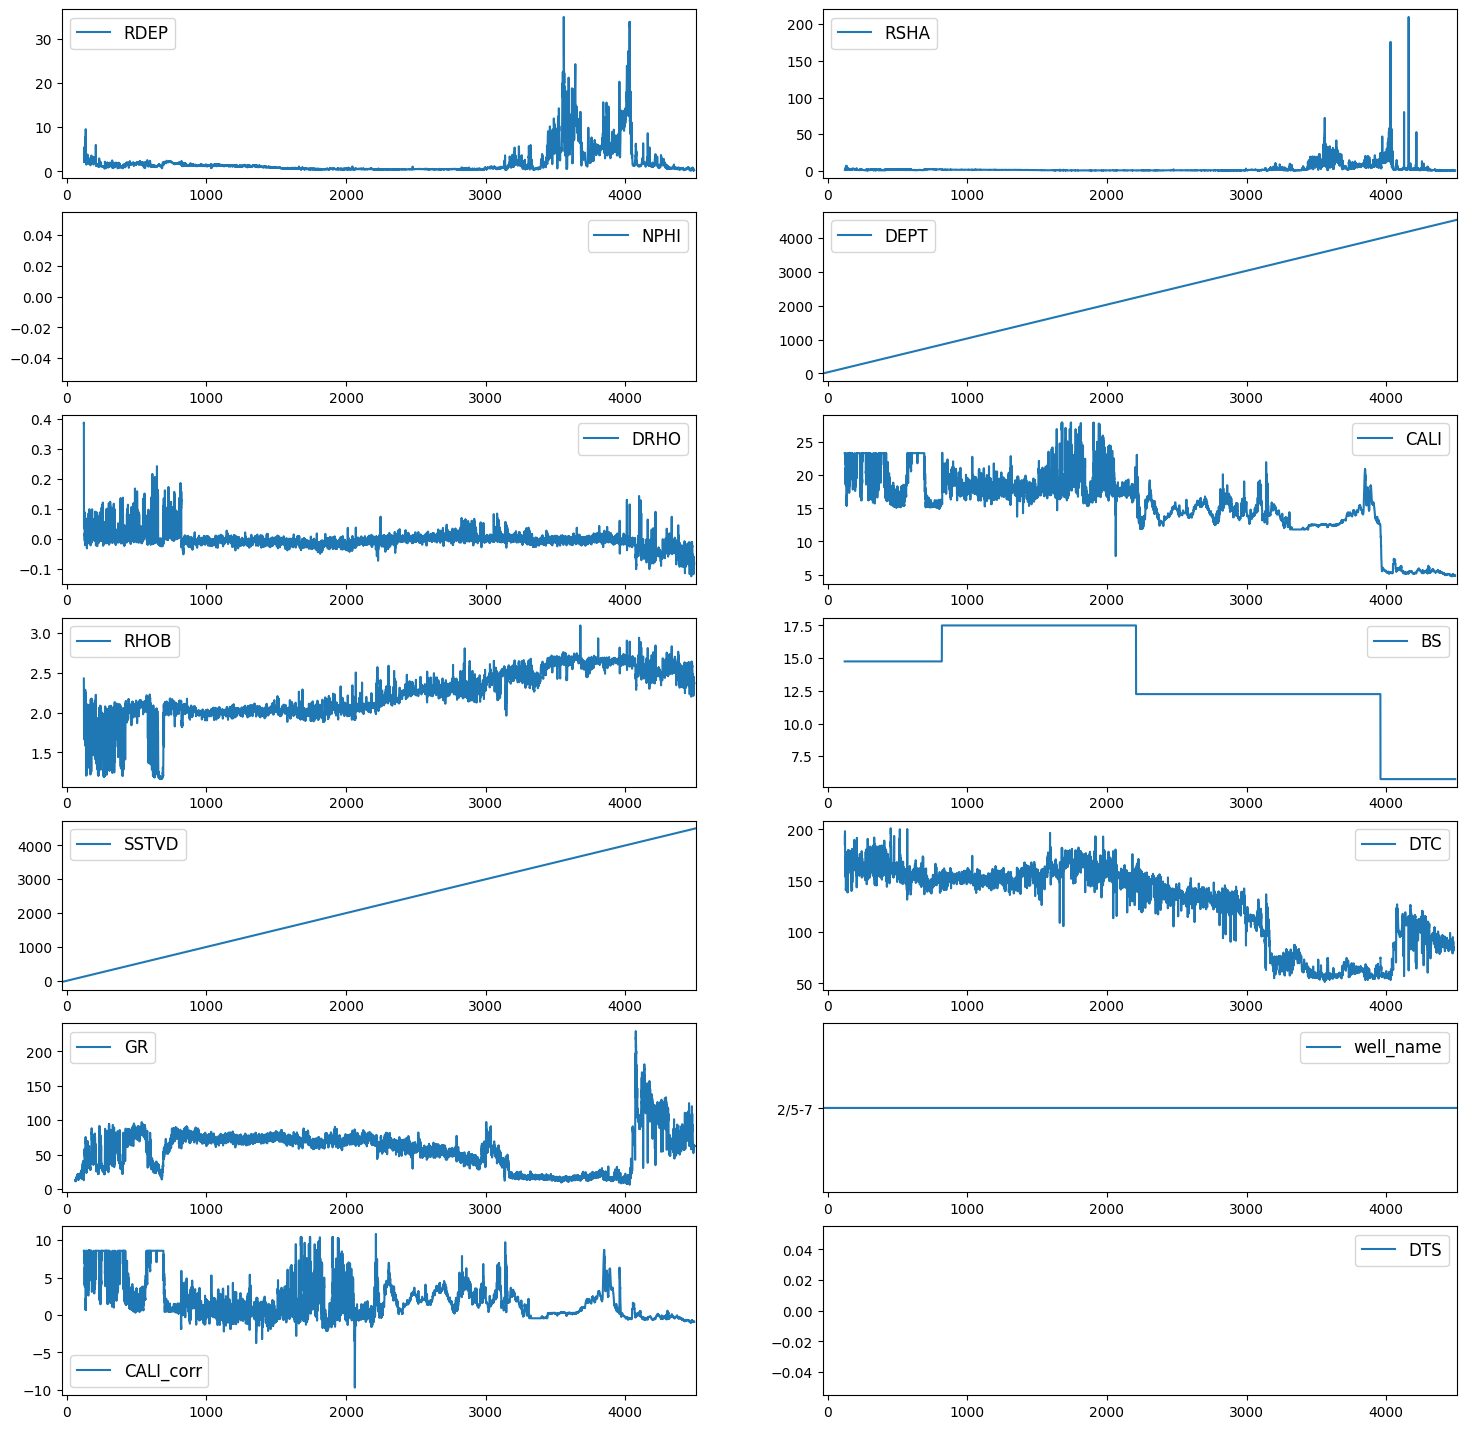

In [ ]:
cols = target_result_df.columns

# counter for subplots
l1=int(np.ceil(len(cols)/2)) # always rounds to the next higher

# figure specs
fig, ax = plt.subplots(nrows=l1, ncols=2, figsize=(18, 18))
ax = ax.flatten()

m1=target_result_df['SSTVD'][target_result_df['well_name'] == wellname].min()
m2=target_result_df['SSTVD'][target_result_df['well_name'] == wellname].max()

for i in range(0,len(cols)):
    ax[i].plot(target_result_df['SSTVD'][target_result_df['well_name'] == wellname], target_result_df[cols[i]][target_result_df['well_name'] == wellname], label=cols[i])
    ax[i].legend(loc="best", fontsize=12)
    ax[i].set_xlim([m1, m2])
